# Projet python 2A : évaluation de la valeure des footballeurs

César Fabiani - Mathis Lecoq

_Ce projet est réalisé dans le cadre du cours de Python de Lino Galiana pour l'année 2023-2024._

### Introduction

**Notre objectif** : Evaluer la valeur d'un joueur. Pour cela nous avons utilisé les données sur le site [**FB**REF](https://fbref.com/fr/) qui contiennent des données détaillés (buts, passes, etc) pour chaque joueur dans chaque match.

**Le projet** : Notre projet se décompose en N étapes : 
1. Extraction des données en scrappant le site [**FB**REF](https://fbref.com/fr/)
2. Identification des variables d'intérets
3. ...

### Structure du répertoire

À la racine du répertoire, on trouve :
- **`README.md`** : présentation détaillée du projet

### Installations et importations

La partie scrapping prenant beaucoup de temps pour éviter de se faire bloquer par le site, elle n'est pas incluse dans ce notebook. Vous pouvez la trouver dans le fichier **`scrapping`**.
Pour information, les installations et importations sont les suivantes :

In [1]:
!sudo apt-get install python3-pip python-dev
!pip install lxml

import bs4
import lxml
import urllib
import requests

from bs4 import BeautifulSoup
from urllib import request

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python3-pip
E: Unable to locate package python-dev


De plus, on utilise le module **`time`** pour espacer les requêtes et le module **`json`** pour stocker les données recueillies : 

In [2]:
import json
import time

Pour traiter les données, nous avons utilisé les modules **`pandas`**, **`numpy`**, **`sklearn`** et **`matplotlib`** :

In [3]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Étape 1 : Extraction des données en scrappant le site [**FB**REF](https://fbref.com/fr/)

_Le code de la partie scraping ne se trouve pas dans le notebook car prennant trop de temps pour s'éxecuter. Vous pouvez le trouvez dans le dossier **`scraping`**.

La partie scraping s'est déroulée en deux étapes. Premièrement le programme **`scraping_FBREF_1`** permet pour une ligue donnée et une saison donnée d'avoir l'ensemble des url des rapports de match correspondant à cette ligue et à cette saison. La liste des url des matchs est exportée vers le fichier json **`liste_url.json`**. Ensuite, les url récoltées sont utilisées par le programme **`scrap_ligue`** qui vient scrapper les tableaux rassemblant les données de chaque joueur. Ainsi une ligne de ce tableau correspond à la performence d'un joueur lors d'un match. Puis les données sont exportées vers le fichier **`statistiques`**. Voici pour exemple les premières lignes du fichier : 

In [4]:
path = "data/data_premierleague_2022_2023_V2.csv"
df_FBREF = pd.read_csv(path)
print(df_FBREF.head())

   Unnamed: 0                Joueur  Numéro de maillot   Nation Emplacement  \
0           0       Odsonne Édouard                 22   fr FRA          FW   
1           1  Jean-Philippe Mateta                 14   fr FRA          FW   
2           2         Wilfried Zaha                 11   ci CIV          LW   
3           3           Jordan Ayew                  9   gh GHA       RW,AM   
4           4          Eberechi Eze                 10  eng ENG          AM   

      Âge  Minutes  Buts  Passes décisives_x  Pénaltys marqués  ...  \
0  24-201       57     0                   0                 0  ...   
1  25-038       33     0                   0                 0  ...   
2  29-268       90     0                   0                 0  ...   
3  30-328       90     0                   0                 0  ...   
4  24-037       85     0                   0                 0  ...   

   Centres_y  Interceptions  Tacles réussis_y  Pénaltys réussis  \
0          0              0    

Une fois la base de données obtenue, nous avons nettoyé la base afin d'obtenir des données sur lesquelles nous pouvons travailler. 

### Étape 2 : Scrapping du site Transfermarkt

In [5]:
path = "/home/onyxia/work/evaluation_football/data/tm.csv"
df_tm = pd.read_csv(path)
df_tm.columns = ['Joueur', 'Valeur', 'Date naissance']
print(df_tm.head())

          Joueur        Valeur     Date naissance
0        Ederson  40,00 mio. €  17 août 1993 (29)
1  Stefan Ortega   9,00 mio. €   6 nov. 1992 (30)
2   Zack Steffen   3,50 mio. €   2 avr. 1995 (28)
3   Scott Carson       200 K €  3 sept. 1985 (37)
4     Rúben Dias  80,00 mio. €   14 mai 1997 (26)


### Étape 3 : Nettoyage des données et fusion des deux bases

Ici il faut mettre ce qui est dans le cleaning pour clean la base FBref (notamment clarifier les positions, c'est le plus important car le modèle est bancal à cause de ça pour l'instant)+ il faut clean la base transfermarkt (transformer les valeurs qui sont en string en valeur numérique avec 30 mil qui devient 30 et 500k qui devient 0.5).

En suite on peut merge les deux bases en faisant un left join . Le code de ça est pour l'instant dans la partie modèle et est un peu brouillon je le 

Une fois ça fait ça nous crée notre base de travail. Je sais pas si on l'exporte ou non. En soit on peut la conserver dans le code pour la suite ou la save et la réouvrir ensuite

Afin de pouvoir faire des statistiques et d'évaluer la valeur des footballeurs, nous devons nettoyer la base issue du site FBREF. Ce nettoyage comporte trois points.

Premièrement, nous devons rajouter à chaque ligne le nombre de point gagnés à l'issu du match (3 pour une victoire, 1 pour une égalité, 0 pour une défaite), pondéré par le temps que le joueur a passé à jouer.

In [6]:
df_FBREF["home"] = np.where(df_FBREF["id_team_A"] == df_FBREF["team tag"], True, False)

def points_gagnes(row):
    """
    This function determines wich teams won, or if there is an equality and return points accordingly.
    """
    if row["id_team_A"] == row["team tag"]:
        if row["score_team_A"] > row["score_team_B"]:
            return 3
        elif row["score_team_A"] == row["score_team_B"]:
            return 1
        else: 
            return 0
    else:
        if row["score_team_B"] > row["score_team_A"]:
            return 3
        elif row["score_team_B"] == row["score_team_A"]:
            return 1
        else:
            return 0

df_FBREF['pts_gagnes'] = df_FBREF.apply(points_gagnes, axis=1)
df_FBREF['pts_apportes'] = df_FBREF['pts_gagnes'] * df_FBREF["Minutes"] / 90

Ensuite nous devons simplifier les positions des joueurs, en effet pour évaluer la valeur d'un joueur, nous devons prendre en compte sa position (un défenseur n'a pas pour objectif de marquer des buts). Cependant il y a trop de position fournies par le site. Nous avons donc condensé les positions en seulement trois positions : attaquant, milieu, défenseur. Nous supprimons également les joueurs ayant le rôle de gardient de but qui est très différent des autres rôles.

In [7]:
# eliminate Goal Keepers
df_FBREF = df_FBREF.loc[df_FBREF['Emplacement'] != 'GK']

def positions(position):
    """
    This function is used to replace the position of each players by a simpler one.
    The only position left are : "Attaquant", "Défenseur" and "Milieu".
    """
    position = position[:2]
    if position in ['FW','LW','RW']:
        return 'Attaquant'
    elif position in ['DF','FB','LB','RB','CB','WB']:
        return 'Défenseur'
    elif position in ['MF','AM','DM','CM','LM','RM','WM']:
        return 'Milieu'

df_FBREF['Position'] = df_FBREF['Emplacement'].apply(positions)
print(df_FBREF)

       Unnamed: 0                Joueur  Numéro de maillot   Nation  \
0               0       Odsonne Édouard                 22   fr FRA   
1               1  Jean-Philippe Mateta                 14   fr FRA   
2               2         Wilfried Zaha                 11   ci CIV   
3               3           Jordan Ayew                  9   gh GHA   
4               4          Eberechi Eze                 10  eng ENG   
...           ...                   ...                ...      ...   
11339          22            Rico Lewis                 82  eng ENG   
11340          23            Nathan Aké                  6   nl NED   
11341          24          Shea Charles                 62  nir NIR   
11342          25       Aymeric Laporte                 14   es ESP   
11343          26           Kyle Walker                  2  eng ENG   

      Emplacement     Âge  Minutes  Buts  Passes décisives_x  \
0              FW  24-201       57     0                   0   
1              FW  

Ensuite nous devons nettoyer la base obtenue à partir du site Transfermrkt. Cela consiste simplement à remplacer les chaines de caractères correspondant au prix des joueurs en flotants.

In [8]:
# supress the line with no price
df_tm = df_tm.loc[df_tm['Valeur'] != '-']

def str_to_float(str):
    """
    This function convert a string to a float.
    """
    L = str.split()
    L[0] = L[0].replace(",",".")
    if L[1]=='K':
        return float(L[0])/1000
    elif L[1]=='mio.':
        return float(L[0])
    else :
        return None


df_tm['Valeur_Millions'] = df_tm['Valeur'].apply(str_to_float)
print(df_tm)

               Joueur        Valeur      Date naissance  Valeur_Millions
0             Ederson  40,00 mio. €   17 août 1993 (29)             40.0
1       Stefan Ortega   9,00 mio. €    6 nov. 1992 (30)              9.0
2        Zack Steffen   3,50 mio. €    2 avr. 1995 (28)              3.5
3        Scott Carson       200 K €   3 sept. 1985 (37)              0.2
4          Rúben Dias  80,00 mio. €    14 mai 1997 (26)             80.0
..                ...           ...                 ...              ...
833   Antoine Semenyo   9,00 mio. €   7 janv. 2000 (23)              9.0
834        Jamal Lowe   1,50 mio. €  21 juil. 1994 (28)              1.5
835   Dominic Solanke  20,00 mio. €  14 sept. 1997 (25)             20.0
836     Kieffer Moore   4,00 mio. €    8 août 1992 (30)              4.0
837  Christian Saydee       400 K €    10 mai 2002 (21)              0.4

[775 rows x 4 columns]


Nous pouvons enfin fusionner les deux bases de données.

In [9]:

df_FBREF.set_index('Joueur', inplace= True)
df_tm.set_index('Joueur', inplace= True)
base_work = pd.merge(df_FBREF, df_tm, how='left', left_index=True, right_index=True)
print(base_work)

                 Unnamed: 0  Numéro de maillot   Nation Emplacement     Âge  \
Joueur                                                                        
Aaron Cresswell          10                  3  eng ENG          LB  32-235   
Aaron Cresswell          23                  3  eng ENG          LB  32-242   
Aaron Cresswell           9                  3  eng ENG          LB  32-249   
Aaron Cresswell          25                  3  eng ENG       CB,LB  32-256   
Aaron Cresswell           8                  3  eng ENG          LB  32-259   
...                     ...                ...      ...         ...     ...   
İlkay Gündoğan            4                  8   de GER          LM  32-184   
İlkay Gündoğan           20                  8   de GER       CM,AM  32-188   
İlkay Gündoğan            6                  8   de GER          DM  32-194   
İlkay Gündoğan           20                  8   de GER          DM  32-202   
İlkay Gündoğan           21                  8   de 

In [10]:
base_work['Joueur'] = base_work.index
base_work = base_work.reset_index(drop = True)
print(base_work)
print(base_work['Valeur'].isna().sum())

       Unnamed: 0  Numéro de maillot   Nation Emplacement     Âge  Minutes  \
0              10                  3  eng ENG          LB  32-235       90   
1              23                  3  eng ENG          LB  32-242       90   
2               9                  3  eng ENG          LB  32-249       90   
3              25                  3  eng ENG       CB,LB  32-256       90   
4               8                  3  eng ENG          LB  32-259       71   
...           ...                ...      ...         ...     ...      ...   
11045           4                  8   de GER          LM  32-184       71   
11046          20                  8   de GER       CM,AM  32-188       90   
11047           6                  8   de GER          DM  32-194       89   
11048          20                  8   de GER          DM  32-202       77   
11049          21                  8   de GER          CM  32-212       90   

       Buts  Passes décisives_x  Pénaltys marqués  Pénaltys tir

### Étape 4 : Statistiques descriptives

Le but de notre modèle est de calculer l'impact d'une action (passe, tir, dribble,...) sur le match. Une fois son impact (positif ou négatif) calculé, nous pouvons en déduire la valeur d'un joueur en regardant le nombre de fois qu'un joueur va faire chaque action.

Pour les actions, nous allons conserver à priori toutes les actions "en jeu" (passe, tir,...) mais éliminer toutes les actions "hors jeu" (pénalty, corner,...). En effet tout joueur peut effectuer cette action et le choix ne démontre pas une meilleure qualité du joueur. Bien sur un joueur réalisant systématiquement ce genre d'action aura en réalité une meilleure valeur que ce qui est prédit dans le modèle. Mais il ne nous est pas possible d'en tenir compte.

Afin de voir qu'elles actions peuvent être considérés comme déterminantes pour déterminer la valeur un joueur, nous pouvons analyser la variance de chaque action en fonction des postes. Plus une action a une variance grande, plus elle nous permettra de déterminer la valeur d'un joueur.

Comme les données comparées avaient des plages de valeurs très différentes les une des autres, nous avons corrigé la variance en divisant par l'espérence 

In [11]:
actions = ['Buts','Passes décisives_x','Total des tirs ','Shots on Target','Cartons jaunes_x',
'Cartons rouges_x','Touches_x','Tacles_x','Interceptions_x','Balles contrées_x','Actions menant à un tir',
'Actions menant à un but','Passes réussies_x','Passes tentées_x','% de passes réussies_x','Passes progressives_x',
'Balle au pied_x','Possessions progressives_x','Dribbles tentés_x','Dribbles réussis_x',
'Distance totale des passes',"Distance parcourue vers l'attaque avec les passes",'Passes réussies (Court)',
'Passes tentées (Court)','% de passes réussies (Court)','Passes réussies (Moyen)','Passes tentées (Moyen)',
'% de passes réussies (Moyen)','Passes réussies (Long)','Passes tentées (Long)','% de passes réussies (Long)',
'Passes clés','Passes dans le dernier tiers du terrain','Passes dans la surface de réparation',
'Centres dans la surface de réparation','Passes tentées','Live-ball Passes','Dead-ball Passes',
'Passe en profondeur','Transversales','Centres_x','Throw-ins Taken','Passes réussies','Passes hors-jeux',
'Passes bloquées_x','Tacles réussis_x','Tacles (ZDéf)','Tacles (MilTer)','Tacles (ZOff)','Dribbleurs taclés',
'Dribbles mis en échec','% of Dribblers Tackled','Tacles manqués','Tirs bloqués','Tcl+Int','Dégagements',
'Erreurs','Touches (SurfRépDéf)','Touches (ZDéf)','Touches (MilTer)','Touches (ZOff)','Touches (SurfRépOff)',
'Touches (Ballon vivant)','% de dribbles réussis','Nombre de fois où le joueur a été taclé',
'Pourcentage de tacles subis lors des tentatives de franchissement','Distance totale parcourue avec le ballon',
"Distance parcourue vers l'attaque en portant la balle","Chevauchées dans le dernier tiers",
"Chevauchées dans la surface de réparation","Mauvais contrôle","Perte de balle","Passes reçues",
"Passes progressives reçues","Deuxième carton jaune","Fautes commises","Fautes provoquées","Hors-jeux",
"Interceptions","Pénaltys concédés","But contre son camp","Récupérations de balle","Aerials Won",
"Aerials Lost","% of Aerials Won"]

variances = pd.DataFrame(index=actions, columns=base_work['Position'].unique())

for position in base_work['Position'].unique():
    for act in actions:
        variance = base_work[base_work['Position'] == position][act].var(ddof=0)
        variance = variance/base_work[base_work['Position'] == position][act].mean()
        variances.at[act, position] = variance

print(variances.head())

                   Défenseur    Milieu Attaquant
Buts                0.968766  1.130229  1.094847
Passes décisives_x  1.032878   0.99836  1.139874
Total des tirs      1.297053  1.578624  1.641714
Shots on Target     1.033262  1.256257  1.232118
Cartons jaunes_x    0.870526    0.8807  0.921117


/tmp/ipykernel_10333/904461720.py:27: RuntimeWarning: invalid value encountered in scalar divide
  variance = variance/base_work[base_work['Position'] == position][act].mean()


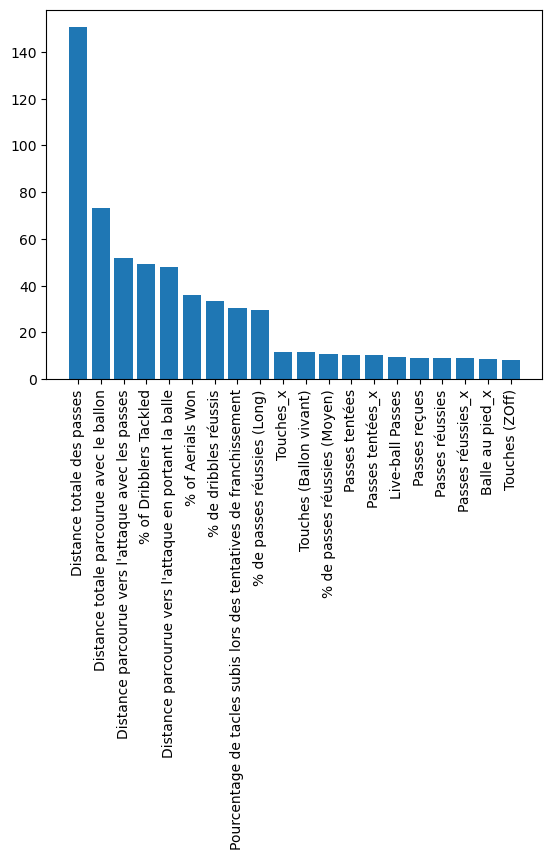

In [12]:
variances=variances.sort_values(by='Attaquant',ascending=False)
plt.bar(variances.head(20).index,variances['Attaquant'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

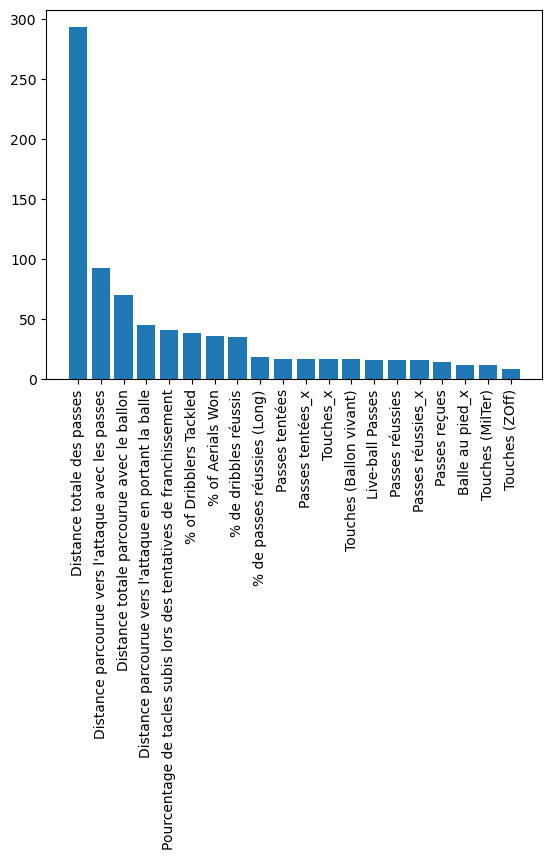

In [13]:
variances=variances.sort_values(by='Milieu',ascending=False)
plt.bar(variances.head(20).index,variances['Milieu'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

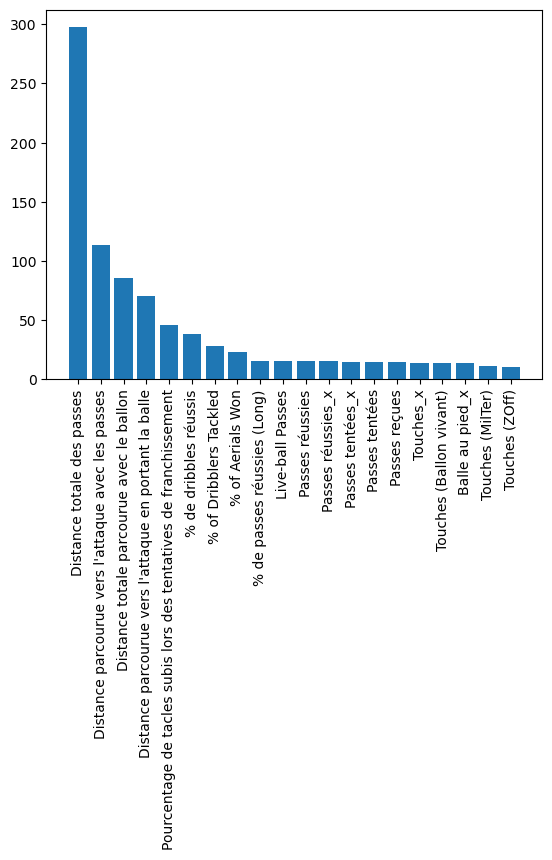

In [14]:
variances=variances.sort_values(by='Défenseur',ascending=False)
plt.bar(variances.head(20).index,variances['Défenseur'].head(20))
plt.xticks(rotation = 'vertical')
plt.show()

### Étape 5 : Modèle

Je mets le modèle temporaire en chargeant des bases.
Comme le merge des deux bases n'est pas encore fait, je le fait là mais infine faudra le placer plus haut

-

In [15]:
base_work = base_work.dropna(subset=['Valeur_Millions'])

### Etude des attaquants

L'étude se fait poste par poste, car les statistiques à prendre en compte pour mesurer la qualité d'un joueur ne sont pas les mêmes selon son poste. On peut supposer qu'un défenseur sera bon s'il est capable de bien tacler les attaquants adverses alors que cela sera de faible utilité pour un attaquant.

On commence donc par la filtrer la base pour ne conserver que les attaquants

In [16]:
base_attaquant = base_work[base_work['Position'] == 'Attaquant']

On crée ensuite une fonction qui permet de récupèrer On crée ensuite une fonction qui permet de récupèrer 

In [17]:
y = base_attaquant['pts_gagnes'].values.reshape(-1,1)

def reg_simple(x,y):
    reg = linear_model.LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    intercept = reg.intercept_
    slope = reg.coef_[0]
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    return intercept, slope, mse, r2

In [18]:
Var_forward = ['Buts', 'Passes décisives_x','Pénaltys marqués', 'Pénaltys tirés', 'Total des tirs ',
       'Shots on Target', 'Cartons jaunes_x', 'Cartons rouges_x', 'Touches_x',
       'Tacles_x', 'Interceptions_x', 'Balles contrées_x','Actions menant à un tir',
       'Actions menant à un but', 'Passes réussies_x', 'Passes tentées_x',
       'Passes progressives_x', 'Balle au pied_x','Possessions progressives_x', 'Dribbles tentés_x', 'Dribbles réussis_x'
       ]

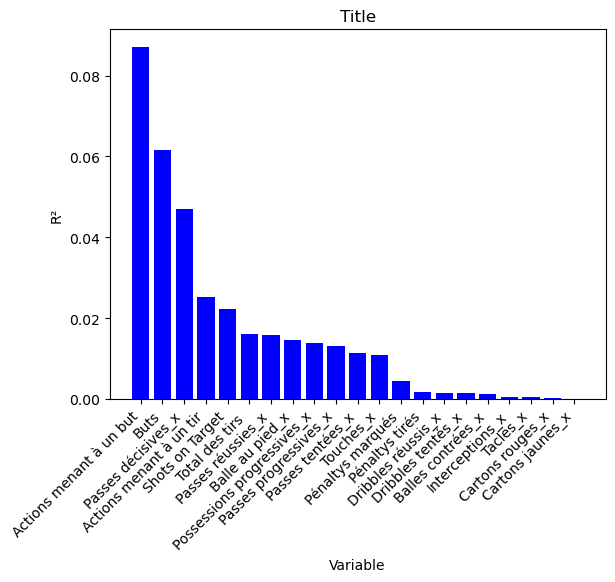

In [19]:
stat_forward = Var_forward
dict_forward = {}
for stat in stat_forward:
    x = base_attaquant[[stat]]
    result_reg = reg_simple(x,y)
    #print(result_reg)
    dict_forward[stat] = result_reg

var = dict_forward.keys()
r2list = [ele[3] for ele in dict_forward.values()]

sorted_data = sorted(zip(var, r2list), key=lambda x: x[1], reverse=True)
var_sorted, r2list_sorted = zip(*sorted_data)

plt.bar(var_sorted, r2list_sorted, color='blue')
plt.xlabel('Variable')
plt.ylabel('R²')
plt.title('Title')
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
var_retenues = ['Buts','Passes décisives_x','Shots on Target','Total des tirs ','Passes progressives_x']
x = base_attaquant[var_retenues]
y = base_attaquant['pts_gagnes'].values.reshape(-1,1)
print(reg_simple(x,y))
intercept, coef, _ , _ = reg_simple(x,y)
list_coef = list(coef)

(array([1.17344779]), array([ 6.89143691e-01,  7.48888780e-01, -3.03978190e-02, -4.92858469e-05,
        3.52057241e-02]), 1.5988696867118373, 0.10345638034430371)


In [21]:
base_attaquant_saison = base_attaquant.groupby('Joueur').agg({'Buts' : 'sum',
                                    'Passes décisives_x' : 'sum', 'Shots on Target' : 'sum',
                                    'Total des tirs ' : 'sum', 'Passes progressives_x' : 'sum', 'Minutes' : 'sum', 'pts_gagnes': 'sum', 'Valeur_Millions' : 'first'}).reset_index()
print(base_attaquant_saison[['Joueur','Minutes']].sort_values(by = 'Minutes', ascending = True))

                 Joueur  Minutes
0    Abdoulaye Doucouré        1
101          Jamal Lowe        1
184      Pascal Struijk        1
124        Joël Veltman        1
117         Jonny Evans        1
..                  ...      ...
178       Ollie Watkins     3037
48           Danny Ings     3180
29          Bukayo Saka     3181
169       Mohamed Salah     3200
87           Harry Kane     3405

[234 rows x 2 columns]


In [22]:
base_attaquant_saison['pts joueurs'] =  base_attaquant_saison[var_retenues[0]] * list_coef[0] + \
                                        base_attaquant_saison[var_retenues[1]] * list_coef[1] + \
                                        base_attaquant_saison[var_retenues[2]] * list_coef[2] + \
                                        base_attaquant_saison[var_retenues[3]] * list_coef[3] + \
                                        base_attaquant_saison[var_retenues[4]] * list_coef[4] 
base_attaquant_saison = base_attaquant_saison[base_attaquant_saison['Minutes'] >= 900]
base_attaquant_saison['pts joueur par 90'] = base_attaquant_saison['pts joueurs'] * 90  / base_attaquant_saison['Minutes']
print(base_attaquant_saison[['Joueur','pts joueur par 90']].sort_values(by = 'pts joueur par 90', ascending= False))

               Joueur  pts joueur par 90
73     Erling Haaland           1.014911
139  Leandro Trossard           0.772114
30      Callum Wilson           0.771927
87         Harry Kane           0.729791
169     Mohamed Salah           0.727663
..                ...                ...
12     Anthony Gordon           0.166277
158     Matheus Cunha           0.159002
55       Demarai Gray           0.145161
174       Neal Maupay           0.055608
58        Diego Costa           0.055351

[74 rows x 2 columns]


Définition du replacement player

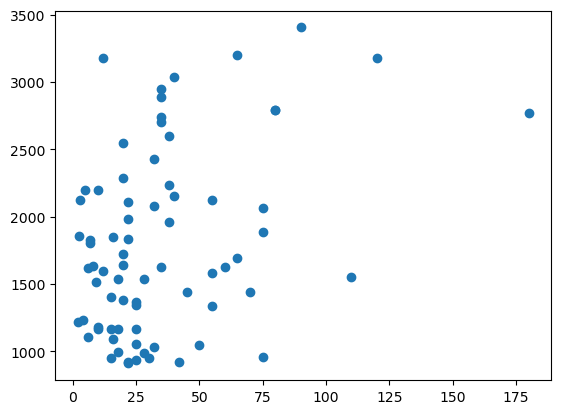

In [23]:
minutes = base_attaquant_saison['Minutes']
value = base_attaquant_saison['Valeur_Millions']

fig, ax = plt.subplots()
ax.scatter(value,minutes)
plt.show()

In [24]:
replacement_attaquant = base_attaquant_saison[(base_attaquant_saison['Valeur_Millions'] <= 10) & (base_attaquant_saison['Valeur_Millions'] >= 1)]

In [25]:
Replacement_performance = replacement_attaquant['pts joueur par 90'].mean()
print(Replacement_performance)

0.2697344209147738


In [26]:
base_attaquant_saison['PAR par 90'] = base_attaquant_saison['pts joueur par 90'] - Replacement_performance
print(base_attaquant_saison[['Joueur','PAR par 90']].sort_values(by = 'PAR par 90',ascending = False))

               Joueur  PAR par 90
73     Erling Haaland    0.745176
139  Leandro Trossard    0.502379
30      Callum Wilson    0.502193
87         Harry Kane    0.460056
169     Mohamed Salah    0.457928
..                ...         ...
12     Anthony Gordon   -0.103458
158     Matheus Cunha   -0.110733
55       Demarai Gray   -0.124573
174       Neal Maupay   -0.214126
58        Diego Costa   -0.214383

[74 rows x 2 columns]


### Étape 6 : Applications du modèle
### Comment aider un manager à construire son équipe

L'objectif de ce modèle simple était de créer une statistique mesurant la performance individuel d'un joueur quelque soit la qualité de l'équipe qui l'entoure. Ainsi nous obtenons le Points Above Replacement qui indique la qualité intrinsèque du joueur. 

La construction de ce modèle répondait au besoin d'une évaluation objective de la qualité d'un joueur. Une application du PAR peut se trouver dans l'aide que cela peut apporter à un manager d'équipe de football, en charge des recrutements et des transferts.

L'idée, popularisée par le manager de l'équipe de baseball d'Oakland au début des années 2000, est de chercher les joueurs qui ont objectivement une grande qualité de jeu mais dont la valeur marchande est sous-évaluée. Cette observation

Nous nous proposons de réaliser cette application.

On commence par créer un graphique qui permet d'observer la relation entre la performance des joueurs, mesurée grâce à notre statistique PAR issue des données FBRef et la valeur marchande des joueurs, issue des donénes TransferMarkt

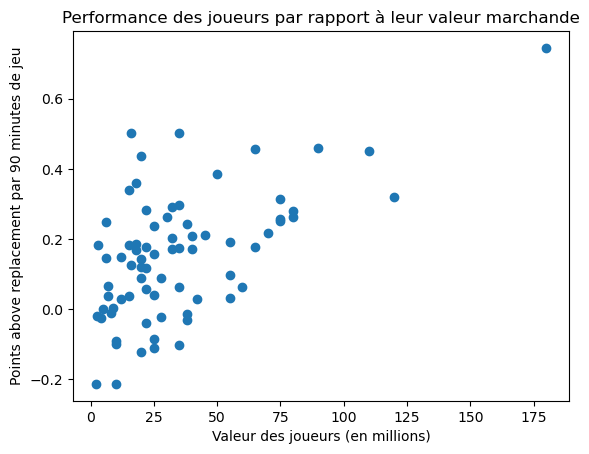

In [27]:
perf = base_attaquant_saison['PAR par 90']
value = base_attaquant_saison['Valeur_Millions']

fig, ax = plt.subplots()
ax.scatter(value,perf)
ax.set_xlabel('Valeur des joueurs (en millions)')
ax.set_ylabel('Points above replacement par 90 minutes de jeu')
ax.set_title('Performance des joueurs par rapport à leur valeur marchande')

plt.show()

On observe une bonne corrélation entre la valeur d'un joueur et sa performance mesurée grâce à la statistique PAR. Cette observation est rassurante dans un premier temps car on imagine bien que les spécialistes du football sont capables de discerner dans les grandes lignes la qualité d'un joueur et que la valeur marchande du joueur reflète en partie cette qualité. Notre statitisque PAR n'est donc pas complètement absurde.

Mais 

In [28]:
base_attaquant_saison['PAR par Millions'] = base_attaquant_saison['PAR par 90'] * 38 / base_attaquant_saison['Valeur_Millions']
print(base_attaquant_saison[['Joueur','PAR par 90','Valeur_Millions','PAR par Millions']].sort_values(by = 'PAR par Millions',ascending = False).head(10))

                Joueur  PAR par 90  Valeur_Millions  PAR par Millions
231            Willian    0.181096              3.0          2.293888
201            Rodrigo    0.248702              6.0          1.575114
30       Callum Wilson    0.502193             16.0          1.192709
33     Carlos Vinícius    0.144620              6.0          0.915930
13     Anthony Martial    0.340677             15.0          0.863048
199       Riyad Mahrez    0.437472             20.0          0.831197
131  Kelechi Iheanacho    0.360505             18.0          0.761066
139   Leandro Trossard    0.502379             35.0          0.545440
217        Solly March    0.282172             22.0          0.487389
48          Danny Ings    0.147295             12.0          0.466436
